In [166]:
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf 
import numpy as np
import matplotlib.pyplot as plt

In [151]:
df_pvs_pf = pd.read_csv('data/TB_pvsage_pf.csv', parse_dates=['Date'])
df_nex_pf = pd.read_csv('data/TB_nex_pf.csv', parse_dates=['Date'])

# keep VUOC and BROME separate

In [152]:
fg_list = ['C4', 'C3', 'AnnGrass', 'Forb', 'SD']

In [153]:
df_pf = df_pvs_pf.append(df_nex_pf)

In [154]:
df_pf['Total_Hits_FG'] = df_pf.loc[:, df_pf.columns.str.contains('hits_') & 
                                   [any(fg in c for fg in fg_list) for c in df_pf.columns]].sum(axis=1)

df_pf['Total_Weight_FG'] = df_pf.loc[:, df_pf.columns.str.contains('weight_') & 
                                   [any(fg in c for fg in fg_list) for c in df_pf.columns]].sum(axis=1)

In [156]:
mod_total = smf.ols('Total_Weight_FG ~ Total_Hits_FG', data=df_pf).fit()

In [155]:
mod_total_fg = smf.ols('Total_Weight_FG ~ hits_C4 + hits_C3 + hits_AnnGrass + hits_Forb + hits_SD', data=df_pf).fit()

In [157]:
mod_c4 = smf.ols('weight_C4 ~ hits_C4', data=df_pf).fit()
mod_c3 = smf.ols('weight_C3 ~ hits_C3', data=df_pf).fit()
mod_ann = smf.ols('weight_AnnGrass ~ hits_AnnGrass', data=df_pf).fit()
mod_forb = smf.ols('weight_Forb ~ hits_Forb', data=df_pf).fit()
mod_sd = smf.ols('weight_SD ~ hits_SD', data=df_pf).fit()

In [158]:
df_pf['pred_Total_FG'] = mod_total_fg.predict()
df_pf['pred_Total'] = mod_total.predict()
df_pf['pred_Indv_FG'] = mod_c4.predict() + mod_c3.predict() + mod_ann.predict() + mod_forb.predict() + mod_sd.predict()

In [159]:
# convert to long format to be able to plot with hue as the FG
df_pf_long = pd.wide_to_long(df_pf.reset_index(), 
                                     stubnames=['hits', 'weight'], 
                                     i=['Site', 'Exclosure', 'Disturbance', 'Plot Name', 'Date'], 
                                     j='FG', 
                                     sep="_", 
                                     suffix=r'\w+').reset_index()

df_pf_pred_long = pd.wide_to_long(df_pf.reset_index(), 
                                     stubnames=['pred'], 
                                     i=['Site', 'Exclosure', 'Disturbance', 'Plot Name', 'Date'], 
                                     j='Type', 
                                     sep="_", 
                                     suffix=r'\w+').reset_index()

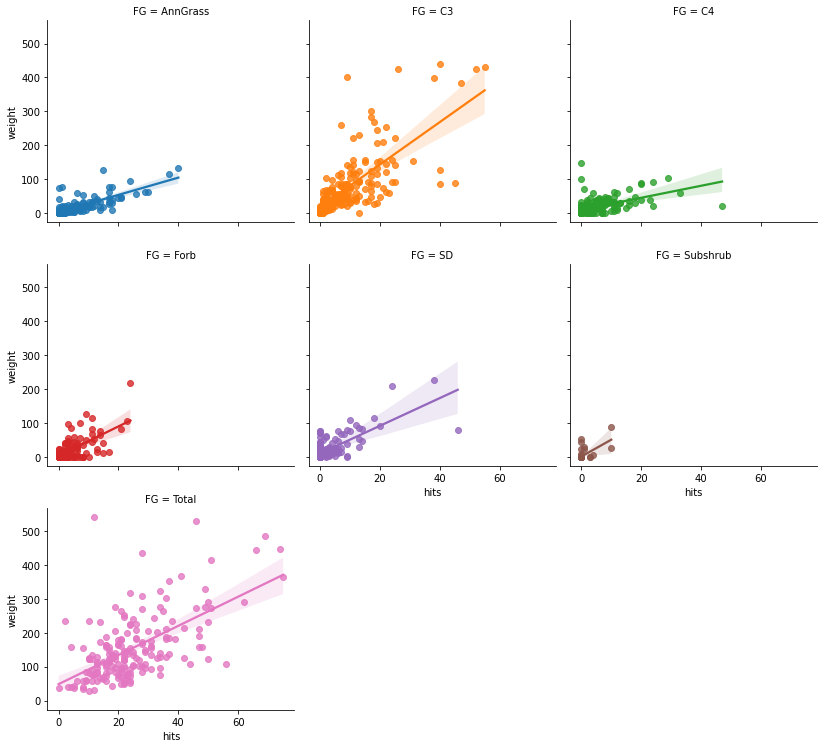

In [160]:
# plot linear fits for each functional group (FG)
sns.lmplot(x='hits',
           y='weight',
           col='FG',
           col_wrap=3,
           hue='FG',
           data=df_pf_long,
           scatter=True, height=3.5, aspect=1.1)

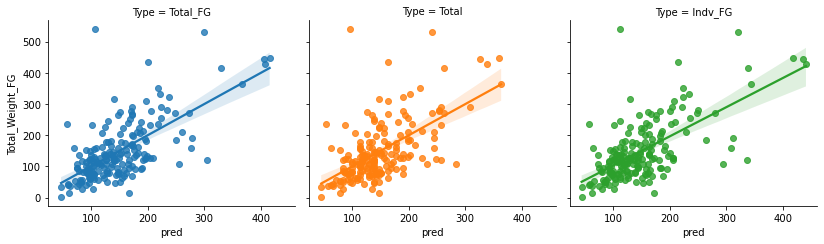

In [161]:
# plot linear fits for each model type
sns.lmplot(x='pred',
           y='Total_Weight_FG',
           col='Type',
           col_wrap=3,
           hue='Type',
           data=df_pf_pred_long,
           scatter=True, height=3.5, aspect=1.1)

In [162]:
# calculate weighted R^2-adj for individual FG models
fg_r2_weights = []
for fg in fg_list:
    fg_r2_weights.append(df_pf['weight_' + fg].sum()/df_pf['Total_Weight_FG'].sum())
fg_r2_avg = np.average([mod_c4.rsquared_adj, mod_c3.rsquared_adj, mod_ann.rsquared_adj, mod_forb.rsquared_adj, mod_sd.rsquared_adj],
        weights=fg_r2_weights)

In [163]:
print('\n----- Final adjusted/weighted R^2 -----\n')
print('Total weight by total hits = ' + str(round(mod_total.rsquared_adj, 2)))
print('Total weight by FG hits = ' + str(round(mod_total_fg.rsquared_adj, 2)))
print('Sum of FG weights by FG hits = ' + str(round(fg_r2_avg, 2)) + '  (weighted average)')

print('\n\n----- Final MAE ' + '(note: average weight = ' + str(round(df_pf['Total_Weight_FG'].mean(), 2)) + ')' + ' -----\n')
print('Total weight by total hits = ' + str(round(df_pf.apply(lambda x: abs(x['pred_Total'] - x['Total_Weight_FG']), axis=1).mean(), 2)))
print('Total weight by FG hits = ' + str(round(df_pf.apply(lambda x: abs(x['pred_Total_FG'] - x['Total_Weight_FG']), axis=1).mean(), 2)))
print('Sum of FG weights by FG hits = ' + str(round(df_pf.apply(lambda x: abs(x['pred_Indv_FG'] - x['Total_Weight_FG']), axis=1).mean(), 2)))

print('\n\n----- Final MRAE -----\n')
print('Total weight by total hits = ' + str(round(df_pf.apply(lambda x: abs((x['pred_Total'] - x['Total_Weight_FG']) / x['Total_Weight_FG']), axis=1).mean(), 2)))
print('Total weight by FG hits = ' + str(round(df_pf.apply(lambda x: abs((x['pred_Total_FG'] - x['Total_Weight_FG']) / x['Total_Weight_FG']), axis=1).mean(), 2)))
print('Sum of FG weights by FG hits = ' + str(round(df_pf.apply(lambda x: abs((x['pred_Indv_FG'] - x['Total_Weight_FG']) / x['Total_Weight_FG']), axis=1).mean(), 2)))


----- Final adjusted/weighted R^2 -----

Total weight by total hits = 0.36
Total weight by FG hits = 0.43
Sum of FG weights by FG hits = 0.49  (weighted average)


----- Final MAE (note: average weight = 148.52) -----

Total weight by total hits = 53.66
Total weight by FG hits = 50.49
Sum of FG weights by FG hits = 51.52


----- Final MRAE -----

Total weight by total hits = 0.74
Total weight by FG hits = 0.72
Sum of FG weights by FG hits = 0.72


In [164]:
print('\n----- adjusted R^2 for individual FG models -----\n')
print('C4 = ' + str(round(mod_c4.rsquared_adj, 2)))
print('C3 = ' + str(round(mod_c3.rsquared_adj, 2)))
print('Annual grass = ' + str(round(mod_ann.rsquared_adj, 2)))
print('Forb = ' + str(round(mod_forb.rsquared_adj, 2)))
print('SD = ' + str(round(mod_sd.rsquared_adj, 2)))


----- adjusted R^2 for individual FG models -----

C4 = 0.27
C3 = 0.5
Annual grass = 0.64
Forb = 0.48
SD = 0.53


<AxesSubplot:>

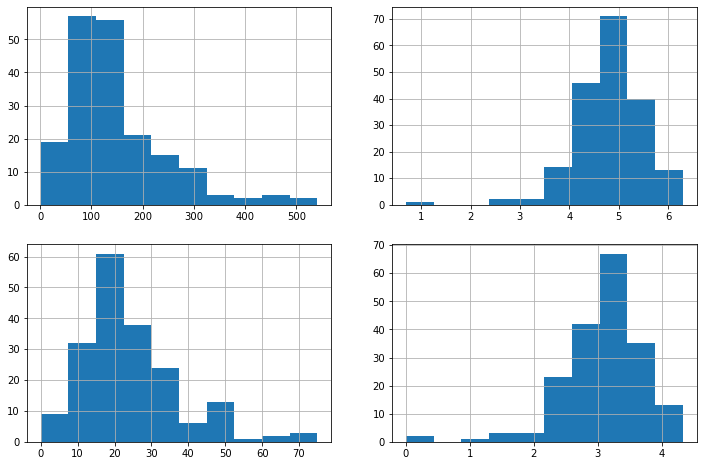

In [171]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
df_pf['Total_Weight_FG'].hist(ax=ax[0, 0])
df_pf['Total_Weight_FG'].transform(lambda x: np.(1 + x)).hist(ax=ax[0, 1])
df_pf['Total_Hits_FG'].hist(ax=ax[1, 0])
df_pf['Total_Hits_FG'].transform(lambda x: np.log(1 + x)).hist(ax=ax[1, 1])

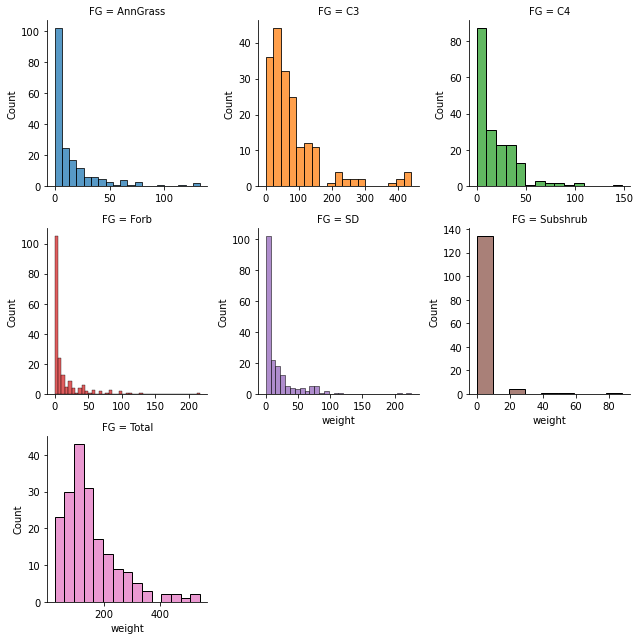

In [199]:
g = sns.FacetGrid(data=df_pf_long, hue='FG', col='FG', col_wrap=3, sharex=False, sharey=False)
g.map(sns.histplot, 'weight')

### other data
* PVSAGE ready next week
* NEX clipping will work - think about fences, which plots which will work with satellite training